# **Project Report**
**Coauthorship Network Analysis for CV/AI Research from ArXiv**

Bin Duan (A20479442) \& Ye Zhu (A20479446)

# **Introduction**

In this project, we aim to analyze the coauthorship network for popular computer vision research topics and papers via our dataset collected from the arXiv, one of the largest open-access repositories of electronic preprints. 

The research in Computer Vision (CV) area has attracted emerging attention in recent years, resulting in a rapidly growing number of research papers that prompt the development of CV, as well as AI in general. As researchers in CV, the collaborations among different research groups and authors play a significant role in everyday work-life. Therefore, our objective for this project is to investigate the coauthorship network, starting from a group of selected prestigious and high-impact CV researchers.

The report follows the structure as below: In the Data Collection Section, we describe how we use the arXiv API python package to search and crawl the raw data from arXiv based on a list of selected researchers. In the Data Visualization Section, we introduce our method to gradually build the coauthorship network based on our collected dataset. We then visualize the network using the Networkx package. In the Network Measures Section, we calculate different network measures based on our coauthorship network graph. Finally, we analyze the network and provide our discussions to conclude the project. All the source codes and implementations are also given in the report, which can be easily executed and testified. 

# **Data Collection**

In this section, we describe the process of collecting the desired data from arXiv based on selected researchers. 

Considering our objective to build a coauthorship network whose nodes are usually represented by a researcher, we start the data collection process by considering specific CV/AI researchers. One of the challenges to building such a coauthorship lies within the fact that we might end up with a very sparse graph if the authors in our graph nodes have no collaborations with others in reality. Therefore, to avoid the above situation, we manually define a list of selected prestigious and high-impact CV researchers. Specifically, we manually verify from Google Scholar that the listed researchers more or less have collaborations with each other, which helps to effectively resolve the sparse network concern. The names of 10 selected authors are given in our implementation shown below. Next, we use those author names as queries and retrieve the searching results (maximum 50) sorted by relevance. During the collection process, we crawl the data with paper id, title, authors, categories, abstract, journal reference (if exists), and arXiv links information. Finally, we store the collected data in a .pkl file for further usage. 

<!-- ### **Prerequisite: Install arXiv api** -->
#### **Implementation**

In [1]:
!pip install arxiv

     |████████████████████████████████| 81 kB 4.3 MB/s 
  Created wheel for sgmllib3k: filename=sgmllib3k-1.0.0-py3-none-any.whl size=6066 sha256=cbe53cfb2104dce7c603c25bed00e2342b60eca607670fb4f08a30e5b329ba2d
  Stored in directory: /root/.cache/pip/wheels/73/ad/a4/0dff4a6ef231fc0dfa12ffbac2a36cebfdddfe059f50e019aa
Successfully built sgmllib3k


In [2]:
import arxiv
import pickle
from itertools import combinations
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

In [3]:
authors = ['Kaiming He', 'Zhuowen Tu', 'Alan Yuille', 'Lingxi Xie', 'Ross Girshick', 'Antonio Torralba', 'Carl Vondrick', 'Pieter Abbeel', 'Trevor Darrell', 'Kristen Grauman']

data = []
for q in authors:

  search = arxiv.Search(
    query = q,
    max_results = 50,
    sort_by = arxiv.SortCriterion.Relevance
  )

  papers = []
  for c, result in enumerate(search.results()):

      # print(q)
      if len(result.authors) < 2:
        continue
      if q not in [str(i) for i in result.authors]:
        # print([str(i) for i in result.authors])
        continue
      else:
        paper = {}
        paper['id'] = result.entry_id
        paper['title'] = result.title

        paper['authors'] = [str(i) for i in result.authors]
        paper['categories'] = result.categories
        paper['abstract'] = result.summary
        paper['journal_ref'] = result.journal_ref
        paper['links'] = result.links
        papers.append(paper)

  print(f'checking author: {q}, paper nums: {len(papers)}')
  
  data.extend(papers)

## Store data in a pickle file
with open('arxiv_data_authors.pkl', 'wb') as fp:
  pickle.dump(data, fp)

checking author: Kaiming He, paper nums: 44
checking author: Zhuowen Tu, paper nums: 41
checking author: Alan Yuille, paper nums: 30
checking author: Lingxi Xie, paper nums: 50
checking author: Ross Girshick, paper nums: 48
checking author: Antonio Torralba, paper nums: 49
checking author: Carl Vondrick, paper nums: 41
checking author: Pieter Abbeel, paper nums: 50
checking author: Trevor Darrell, paper nums: 50
checking author: Kristen Grauman, paper nums: 50


# **Data Visualization**

In this section, we show the process of building and visualizing the coauthorship network based on the data we have just collected. 

We start by extracting the 'authors' information from our preliminarily crawled dataset and filter the repeated researchers. Next, we define a graph structure and add the author names as nodes to the graph. After having constructed the nodes, we then add the edges between nodes if there is a coauthored paper between two researchers. Specifically, we look into every pair combination of researchers, if their names appear simultaneously in any of the collected papers, then we add an edge connecting the two researchers.

After building the coauthorship graph, the obtained graph contains 747 researchers (nodes) and 2977 edges (coauthorships). In this section, we firstly show the complete graph with all the nodes and edges. Note that the plot may be too dense to visualize in a clear manner due to the relatively large number of nodes and edges, we will plot the subgraph of largest connected components later. 

#### **Implementation: Node: Author, Edge: Coauthorship**

In [4]:
with open('arxiv_data_authors.pkl', 'rb') as fp:
  data = pickle.load(fp)

In [5]:
# configure nodes
author_list = []
for i, paper in enumerate(data):
  author_list.extend(paper['authors'])

author_set = set(author_list)
author_list = list(author_set)

In [6]:
# undirected graph
G = nx.Graph()

In [7]:
# generate a dict holding the author for fast mapping
author_mapping_dict = {}
int2labels = {}
for i, au in enumerate(author_list):
  author_mapping_dict[au] = i
  int2labels[i] = au
  G.add_node(i, name = au)

In [8]:
# add edges
for i in range(len(data)):
  for (au0, au1) in combinations(data[i]['authors'], 2):
    G.add_edge(author_mapping_dict[au0], author_mapping_dict[au1])

In [9]:
print(f'Number of nodes: {G.number_of_nodes()}, number of edges: {G.number_of_edges()}')

Number of nodes: 747, number of edges: 2977


In [10]:
G = nx.relabel_nodes(G, int2labels)

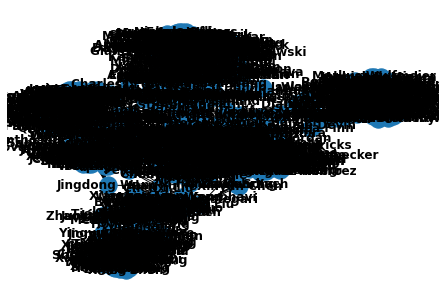

In [11]:
# This plot may be overwhelming, we plot its subgraph of 
# largest connected components later.
nx.draw(G, with_labels=True, font_weight='bold')

# **Network Measures**

In this section, we calculate three network measures based on the final graph we build from the previous section, note that our coauthorship network is an undirected graph. We explain the calculation details for the degree distribution, the eigenvector centrality, and the clustering coefficient, respectively. In addition, we also visualize the subgraph of the largest connected components.

**Degree Distribution**: counts the number of edges for each node and shows the results in form of a histogram.

**Eigenvector centrality**: first computes the eigenvalues of the adjacency matrix of the graph, then selects the largest eigenvalue $λ$ to get the corresponding eigenvector, which represents the eigenvector centralities for the graph.

**Clustering coefficient**: a measure of the degree to which nodes in a graph tend to cluster together. We calculate the global version of the clustering coefficient, which is computed using the formula:
$C_u = \frac{2T(u)}{D(u)(D(u)-1)}$, where $T(u)$ denotes the number of triangles through node $u$, and $D(u)$ is the degreee of node $u$. 

The implementation details and visualizations for the above metrics are shown below.

#### **Implementation**

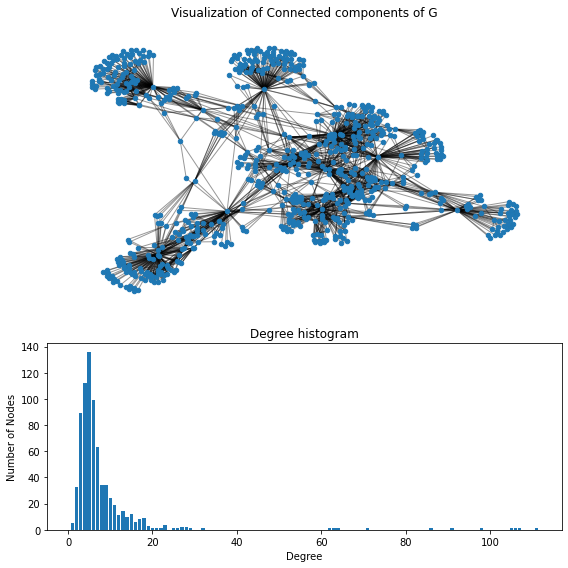

In [12]:
fig = plt.figure("Degree of co-author graph", figsize=(8, 8))
axgrid = fig.add_gridspec(5, 4)

# largest connected components
ax0 = fig.add_subplot(axgrid[0:3, :])
Gcc = G.subgraph(sorted(nx.connected_components(G), key=len, reverse=True)[0])
pos = nx.spring_layout(Gcc, seed=1024)
nx.draw_networkx_nodes(Gcc, pos, ax=ax0, node_size=20)
nx.draw_networkx_edges(Gcc, pos, ax=ax0, alpha=0.4)
ax0.set_title("Visualization of Connected components of G")
ax0.set_axis_off()

# degree histogram
ax1 = fig.add_subplot(axgrid[3:, :])
degree_sequence = sorted([d for n, d in G.degree()], reverse=True)
ax1.bar(*np.unique(degree_sequence, return_counts=True))
ax1.set_title("Degree histogram")
ax1.set_xlabel("Degree")
ax1.set_ylabel("Number of Nodes")

fig.tight_layout()
plt.show()

**Two alternative metrics**

**Eigenvector Centrality**

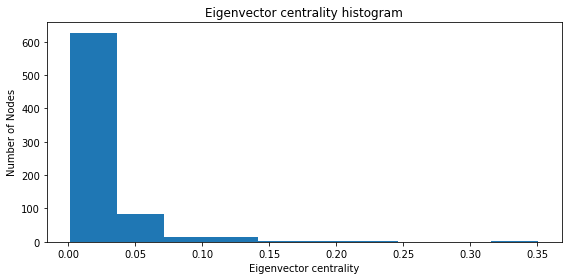

In [13]:
centrality = nx.eigenvector_centrality(G)
list_centrality = [c for v, c in centrality.items()]
list_names = [v for v, c in centrality.items()]

fig = plt.figure("Eigenvector centrality of co-author graph", figsize=(8, 4))
axgrid = fig.add_gridspec(3, 3)

ax0 = fig.add_subplot(axgrid[0:3, :])

ax0.hist(list_centrality)
ax0.set_title("Eigenvector centrality histogram")
ax0.set_xlabel("Eigenvector centrality")
ax0.set_ylabel("Number of Nodes")

fig.tight_layout()
plt.show()

In [14]:
# print most N influential researchers
N = 5
for ind in np.argpartition(list_centrality, -N)[-N:]:
  print(f'name: {list_names[ind]}\t centrality: {list_centrality[ind]:0.4f}')

name: Alan Yuille	 centrality: 0.1724
name: Kaiming He	 centrality: 0.1875
name: Trevor Darrell	 centrality: 0.2070
name: Lingxi Xie	 centrality: 0.2163
name: Ross Girshick	 centrality: 0.3506


**Clustering coefficient**

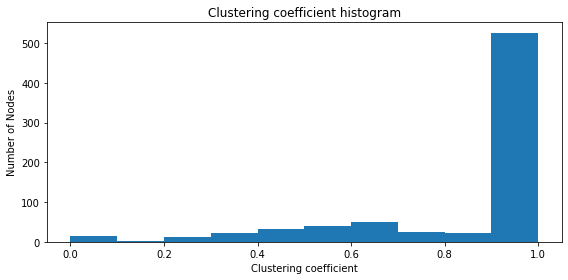

In [15]:
ccf = nx.clustering(G)
ccs = [c for v, c in ccf.items()]

fig = plt.figure("Clustering coefficient of co-author graph", figsize=(8, 4))
axgrid = fig.add_gridspec(3, 3)

ax0 = fig.add_subplot(axgrid[0:3, :])
ax0.hist(ccs)
ax0.set_title("Clustering coefficient histogram")
ax0.set_xlabel("Clustering coefficient")
ax0.set_ylabel("Number of Nodes")

fig.tight_layout()
plt.show()

# **Observation \& Discussion**

In this section, we provide our analysis and discussions on the results obtained from the previous section. 

For the visualized subgraph of the largest connected components, we observe that there exist obvious groups among the researchers, indicating that the CV/AI research communities are often closely clustered in form of collaborations. In practice, authors from similar backgrounds (e.g., universities, companies) often work together on research projects.

For the eigenvector centrality, it implies the impact of each researcher in our coauthorship network. We list five authors with the highest centrality values, it is worth noting that all the five researchers come from our initially selected researcher list. The above observation also demonstrates that the researcher list used for data collection is indeed effective.

For the clustering coefficients, we can draw a similar conclusion as in the first metric analysis, which implies the fact that the researchers often closely in groups with strong connections. 

To conclude, in this project, we collect the data from arXiv to investigate the coauthorship network for CV/AI researchers, specifically by building the graph and computing certain metrics, as well as providing an analysis based on our observations.

# **Reference**
[1] NetworkX, https://networkx.org/documentation/stable/index.html \
[2] ArXiv API, https://github.com/lukasschwab/arxiv.py

Utility tool: **Export PDF**

In [16]:
# !apt update
# !apt install texlive-xetex texlive-fonts-recommended texlive-generic-recommended
# !pip install pypandoc

In [19]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [23]:
!cp drive/MyDrive/ ./
!jupyter nbconvert --to PDF "CS579_Project_1.ipynb"

cp: -r not specified; omitting directory 'drive/MyDrive/'
[NbConvertApp] WARNING | pattern u'CS579_Project_1.ipynb' matched no files
This application is used to convert notebook files (*.ipynb) to various other
formats.


Options
-------

Arguments that take values are actually convenience aliases to full
Configurables, whose aliases are listed on the help line. For more information
on full configurables, see '--help-all'.

--execute
    Execute the notebook prior to export.
--allow-errors
    Continue notebook execution even if one of the cells throws an error and include the error message in the cell output (the default behaviour is to abort conversion). This flag is only relevant if '--execute' was specified, too.
--no-input
    Exclude input cells and output prompts from converted document. 
    This mode is ideal for generating code-free reports.
--stdout
    Write notebook output to stdout instead of files.
--stdin
    read a single notebook file from stdin. Write the resulting n